In [1]:
###############################################################
##  Authors : Michael Andersen <michael.andersen@aalto.fi>   ##
##            Kunal Ghosh <kunal.ghosh@aalto.fi>             ##
###############################################################
    

%matplotlib inline
import numpy as np
import pylab as plt
import seaborn as snb
from pprint import pprint

from collections import OrderedDict

import tensorflow as tf
tfd = tf.contrib.distributions

import sys
sys.path.append('psis/py/')
from psis import psislw, gpdfitnew

####################################################################################
# Display stuff
####################################################################################
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important;align=center; }</style>"))
np.set_printoptions(precision=4, linewidth=200)

####################################################################################
# style stuff
####################################################################################
snb.set(font_scale=1.5)
red = snb.color_palette()[2]
green = snb.color_palette()[1]
blue = snb.color_palette()[0]
black = 'k'



### Test distributions

In [2]:
npdf = lambda x, m, v: np.exp(-(x-m)**2/(2*v))/np.sqrt(2*np.pi*v)

df_tf = tf.constant(3, dtype='float64')
mean = tf.constant(1, dtype='float64')
scale = tf.constant(1, dtype='float64')

###################################################################################
# Student t
###################################################################################
stud_t = tf.distributions.StudentT(df_tf, 1*mean, scale)

###################################################################################
# Gaussian
###################################################################################
gauss = tf.distributions.Normal(mean, scale)


###################################################################################
# Mixture of Gaussian #1
###################################################################################
mix = tf.constant(0.6, dtype='float64')
gaussmix1 = tfd.Mixture(  cat=tfd.Categorical(probs=[mix, 1.-mix]),   components=[ 
    tfd.Normal(loc=2*mean, scale=scale),
    tfd.Normal(loc=4*mean, scale=0.2*scale),
])


###################################################################################
# Mixture of Gaussian #2
###################################################################################
gaussmix2 = tfd.Mixture(  cat=tfd.Categorical(probs=[mix, 1.-mix]),   components=[ 
    tfd.Normal(loc=mean, scale=scale),
    tfd.Normal(loc=4*mean, scale=0.2*scale),
])



###################################################################################
# Beta
###################################################################################
beta = tf.distributions.Beta(5*mean, 2*mean)



target_dict = OrderedDict([('Gaussian', gauss.log_prob),
                           ('Student t', stud_t.log_prob),
                           ('MoG1', gaussmix1.log_prob),
                           ('MoG2', gaussmix2.log_prob)])





In [3]:
pi_tf = tf.constant(np.pi, dtype='float64')

def fit(log_target_fun, function_name, num_samples, max_itt = 1000, learning_rate = 1e-3, seed=0, params=None):
    
    # Parameters
    if params is None:
        m = tf.Variable(0, name="mean", dtype='float64')
        log_v = tf.Variable(0, name="log_v", dtype='float64')
        log_V0 = tf.Variable(0, name="log_V0", dtype='float64') 
    else:
        m = tf.Variable(params[0], name="mean", dtype='float64')
        log_v = tf.Variable(params[1], name="log_v", dtype='float64')
        log_V0 = tf.Variable(params[2], name="log_V0", dtype='float64') 
    v = tf.exp(log_v)
    V0 = tf.exp(log_V0)

    # Samples for expectations
    samples = tf.random_normal([num_samples], mean=m, stddev=tf.sqrt(v), dtype='float64', seed=seed)

    # Define objective -E[f(exp(-V))]
    log_q = -0.5*tf.square(samples - m)/v - 0.5*tf.log(2*pi_tf*v)
    log_p = log_target_fun(samples)
    V = log_q - log_p
    
    x = tf.exp(-V)
    xs = tf.linspace(tf.constant(1e-2, dtype='float64'), tf.reduce_max(x), 20001)
    
    # Choose map f
    if function_name == "PBBVI, K=1":
        f = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(x), 1)/1)
        fx = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(xs), 1)/1)
        
    elif function_name == "PBBVI, K=3":
        f = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(x), 1)/1 + tf.pow(V0 + tf.log(x), 2)/2 + tf.pow(V0 + tf.log(x), 3)/6)
        fx = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(xs), 1)/1 + tf.pow(V0 + tf.log(xs), 2)/2 + tf.pow(V0 + tf.log(xs), 3)/6)
    
    elif function_name == "PBBVI, K=5":
        f = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(x), 1)/1 + tf.pow(V0 + tf.log(x), 2)/2 + tf.pow(V0 + tf.log(x), 3)/6 + tf.pow(V0 + tf.log(x), 4)/24 + tf.pow(V0 + tf.log(x), 5)/120)
        fx = tf.exp(-V0)*(1 + tf.pow(V0 + tf.log(xs), 1)/1 + tf.pow(V0 + tf.log(xs), 2)/2 + tf.pow(V0 + tf.log(xs), 3)/6 + tf.pow(V0 + tf.log(xs), 4)/24 + tf.pow(V0 + tf.log(xs), 5)/120)
    
    elif function_name == "alpha=0.5":
        alpha=tf.constant(0.5, dtype='float64')
        #f = tf.pow(x, 1-0.5)
        #fx = tf.pow(xs, 1-0.5)
        
        f = tf.pow(x,1-alpha)*tf.pow(tf.exp(-V0), alpha) - alpha*tf.exp(-V0)/(1-alpha)
        fx = tf.pow(xs,1-alpha)*tf.pow(tf.exp(-V0), alpha) - alpha*tf.exp(-V0)/(1-alpha)
    
    elif function_name == "KLVI":
        f = tf.log(x)
        fx = tf.log(xs)
    
    elif function_name == "IS":
        f = tf.identity(x)
        fx = tf.identity(xs)
    else:
        raise NotImplementedError("Function %s not implemented!!" % function_name)
    
    
    # objective
    obj = -tf.reduce_mean( f )
    
    # moments from IS
    Z = -obj
    moment1, moment2 = tf.reduce_mean(samples*f)/Z, tf.reduce_mean(tf.square(samples)*f)/Z
    
    # Init & Optimize
    # opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(obj)
    grads_and_vars = tf.train.AdamOptimizer(learning_rate=learning_rate).compute_gradients(obj)
    
    if function_name.startswith("PBBVI"):
        grads_and_vars_updated = []
        for grad, var in grads_and_vars:
            if var.name.startswith("log_V0") and grad != None:
                # print(grad, var)
                # grads_and_vars[idx][0] = grad and [1] = vars
                grad = grad + obj
                print("[NOTE] gradient updated..")
            grads_and_vars_updated.append((grad, var))
        grads_and_vars = grads_and_vars_updated
            
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).apply_gradients(grads_and_vars)
    init = tf.global_variables_initializer()
    
    # Run
    mhats, vhats, lowerbounds, kfs, kxs = [], [], [], [], []
    
    
    with tf.Session() as sess:

        sess.run(init)
        for itt in range(max_itt):
            mhat, vhat, bound, fhat, xhat = sess.run([m, v, obj, f, x])
            kx, _  = gpdfitnew(xhat)
            kf, _  = gpdfitnew(fhat)
            
            mhats.append(mhat)
            vhats.append(vhat)
            lowerbounds.append(-bound)
            kfs.append(kf)
            kxs.append(kx)

            sess.run(opt)    
            
            if (itt+1) % 1000 == 0:
                sys.stdout.write('.') # or print(i, flush=True) ?
                sys.stdout.flush()
            
        
        
        mhat, vhat = m.eval(), v.eval()
        mhats.append(mhat)
        vhats.append(vhat)
            
        moment1hat, moment2hat = moment1.eval(), moment2.eval()
        xshat, fxhat, xhat, fhat, V0hat = sess.run([xs, fx, x, f, V0])
                        
        
    #lowerbounds = np.log(np.array(lowerbounds))       
    lowerbounds = np.array(lowerbounds)

    
    return fhat, xhat, mhat, vhat, lowerbounds, moment1hat, moment2hat,  V0hat, mhats, vhats, xshat, fxhat, np.array(kfs), np.array(kxs)


### Compute true

In [4]:
def compute_true(log_target_fun, xmin=-20, xmax=20, N = 20000):
    # sweep true
    xs = np.linspace(xmin, xmax, N)
    xs_tf = tf.constant(xs, dtype='float64')
    init = tf.global_variables_initializer()

    target_vals = tf.exp(log_target_fun(xs_tf))

    with tf.Session() as sess:
        sess.run(init)   
        true_target = sess.run(target_vals)
    
    # true evidence
    Ztrue = np.trapz(true_target, xs)
    m1 = np.trapz(xs*true_target, xs)/Ztrue
    m2 = np.trapz(xs**2*true_target, xs)/Ztrue
    
    
    return xs, true_target, Ztrue, m1, m2



### Compute PBBVI and KLVI solution for toy problem

In [5]:
def make_figure(function_name, target_name, num_samples = 20000, seed = 0, max_itt =  5000, log=True, learning_rate=1e-3):
    

    # get target distribution
    log_target_fun = target_dict[target_name]
        
    # Compute true quantities
    zs, true_target, Ztrue, m1, m2 = compute_true(log_target_fun)  
    
    # Fit approximation
    fhat, xhat, mhat, vhat, lowerbounds, moment1hat, moment2hat, V0hat, mhats, vhats, xs, fx, kfs, kxs = fit(log_target_fun, function_name, num_samples=num_samples, seed=seed, max_itt=max_itt, learning_rate=learning_rate) # , 
        
    # Fit Generalized Pareto dist.
    kx, _  = gpdfitnew(xhat)
    kf, _  = gpdfitnew(fhat)
    
    # Plot settings
    xmin = -1#np.percentile(xhat, 1)
    xmax = 5#np.percentile(xhat, 99)
    num_bins = 100

    # Log?
    if log and np.min(fhat) > 0:
        g = lambda x: np.log10(x)
        print('Plotting log scale')
        xmin = 1e-3
    else:
        g = lambda x: x
        
    # Compute empirical mean of (x, f(x))
    xmean, fmean = np.mean(g(xhat)), np.mean(g(fhat))

    plt.figure(figsize=(30, 16))

    ##################################################################################################
    # Plot histogram of f(x)
    ##################################################################################################
    plt.subplot(2, 4, 1)
    plt.hist(g(fhat), num_bins, density=True, orientation="horizontal", color=blue);
    plt.axhline(fmean, color='k', linestyle='--')
    plt.title('K = %3.2f, S = %d' % (kf, num_samples))
    plt.ylabel('f(x)')
    plt.ylim((g(xmin), g(xmax)))
    plt.gca().invert_xaxis()

    ##################################################################################################
    # Plot f function
    ##################################################################################################
    plt.subplot(2, 4, 2)
    plt.plot(g(xhat), g(fhat), '.', color=blue, alpha=0.4, markersize=15)
    plt.plot([g(xmin), g(xmax)], [g(xmin), g(xmax)], 'k-')
    plt.plot(g(xs), g(fx), color='r', linewidth=3)
    plt.plot(np.exp(-V0hat), np.exp(-V0hat), 'c.', markersize=20)
    plt.xlim((g(xmin), g(xmax)))
    plt.ylim((g(xmin), g(xmax)))
    plt.plot([xmean, xmean], [g(xmin), fmean], 'k--')
    plt.plot([g(xmin), xmean], [fmean, fmean], 'k--')
    plt.title('Approximating %s using %s' % (target_name, function_name), fontweight='bold')

    ##################################################################################################
    # Plot histogram of x
    ##################################################################################################
    plt.subplot(2, 4, 6)
    plt.hist(g(xhat), num_bins, density=True, color=blue);
    plt.axvline(xmean, color='k', linestyle='--')
    plt.title('K = %3.2f, S = %d' % (kx, num_samples))
    plt.xlabel('$x = e^{-V}$')
    plt.xlim((g(xmin), g(xmax)))
    plt.gca().invert_yaxis()

    ##################################################################################################
    # Plot target and approximation
    ##################################################################################################
    plt.subplot(2, 4, 5)
    plt.plot(zs, npdf(zs, mhats[0], vhats[0]), color=red, linestyle='--', alpha=0.5, label='Init approximation')
    plt.plot(zs, npdf(zs, mhat, vhat), color=red, label='Approximation')
    plt.plot(zs, true_target, color=black, linestyle='--', label='True posterior')
    plt.errorbar(moment1hat, -0.01, xerr=2*np.sqrt(moment2hat - moment1hat**2), fmt='o', color=red)
    plt.xlim((-9, 9))
    plt.xlabel('Parameter $\\theta$')
    plt.legend()

    ##################################################################################################
    # Plot trajectory of mean and variance
    ##################################################################################################
    plt.subplot(2, 4, 3)
    plt.plot(mhats, vhats)
    plt.plot(mhats[0], vhats[0], 'g.', markersize=20)   
    # indicate number of iterations
    for itt in np.arange(999, max_itt, 1000):
        plt.plot(mhats[itt], vhats[itt], 'k.', markersize=20)
        
    plt.plot(mhats[-1], vhats[-1], 'r.', markersize=20)
        
    plt.xlabel('Mean')
    plt.ylabel('Variance')

    ##################################################################################################
    # Plot lowerbound
    ##################################################################################################
    plt.subplot(2, 4, 4)
    plt.plot(lowerbounds, color=red, alpha=0.75, label='Lower bound')
    plt.axhline(Ztrue, color=black, linestyle='--', label='True evidence')
    plt.legend()
    
    ##################################################################################################
    # Plot K for f(x) vs iterations
    ##################################################################################################
    plt.subplot(2, 4, 7)

    plt.hist(g(xhat), num_bins, density=True, color=blue);
    plt.axvline(xmean, color='k', linestyle='--')
    plt.title('Full histogram of x')
    plt.xlabel('$x = e^{-V}$')
    plt.gca().invert_yaxis()
    
    ##################################################################################################
    # Plot K for x & f(x) vs iterations
    ##################################################################################################
    plt.subplot(2, 4, 8)
    plt.plot(kxs, color=red, alpha=0.75, label='k for x')
    plt.plot(kfs, color=blue, alpha=0.75, label='k for f(x)')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('k')
    plt.title('k for x')


    mean_Z = np.mean(fhat)
    print("0th moment: %3.2f (True: %4.3f)" %  (mean_Z, Ztrue))
    print("1st moment: %3.2f (True: %4.3f)" %  (moment1hat, m1))
    print("2nd moment: %3.2f (True: %4.3f)" %  (moment2hat, m2))
    print('')
    print('Range x:\t[%3.2e, %3.2e]' % (np.min(xhat), np.max(xhat)))
    print('Range f(x):\t[%3.2e, %3.2e]' % (np.min(fhat), np.max(fhat)))
        

    plt.pause(1e-3)

### Make figures

----------------------------------------------------------------------------------------------------
Approximating Student t using PBBVI, K=1
----------------------------------------------------------------------------------------------------
[NOTE] gradient updated..


psis/py/psis.py:295: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


...............0th moment: 0.51 (True: 1.000)
1st moment: 1.01 (True: 0.999)
2nd moment: 2.57 (True: 3.669)

Range x:	[7.44e-01, 1.54e+01]
Range f(x):	[4.58e-01, 1.05e+00]


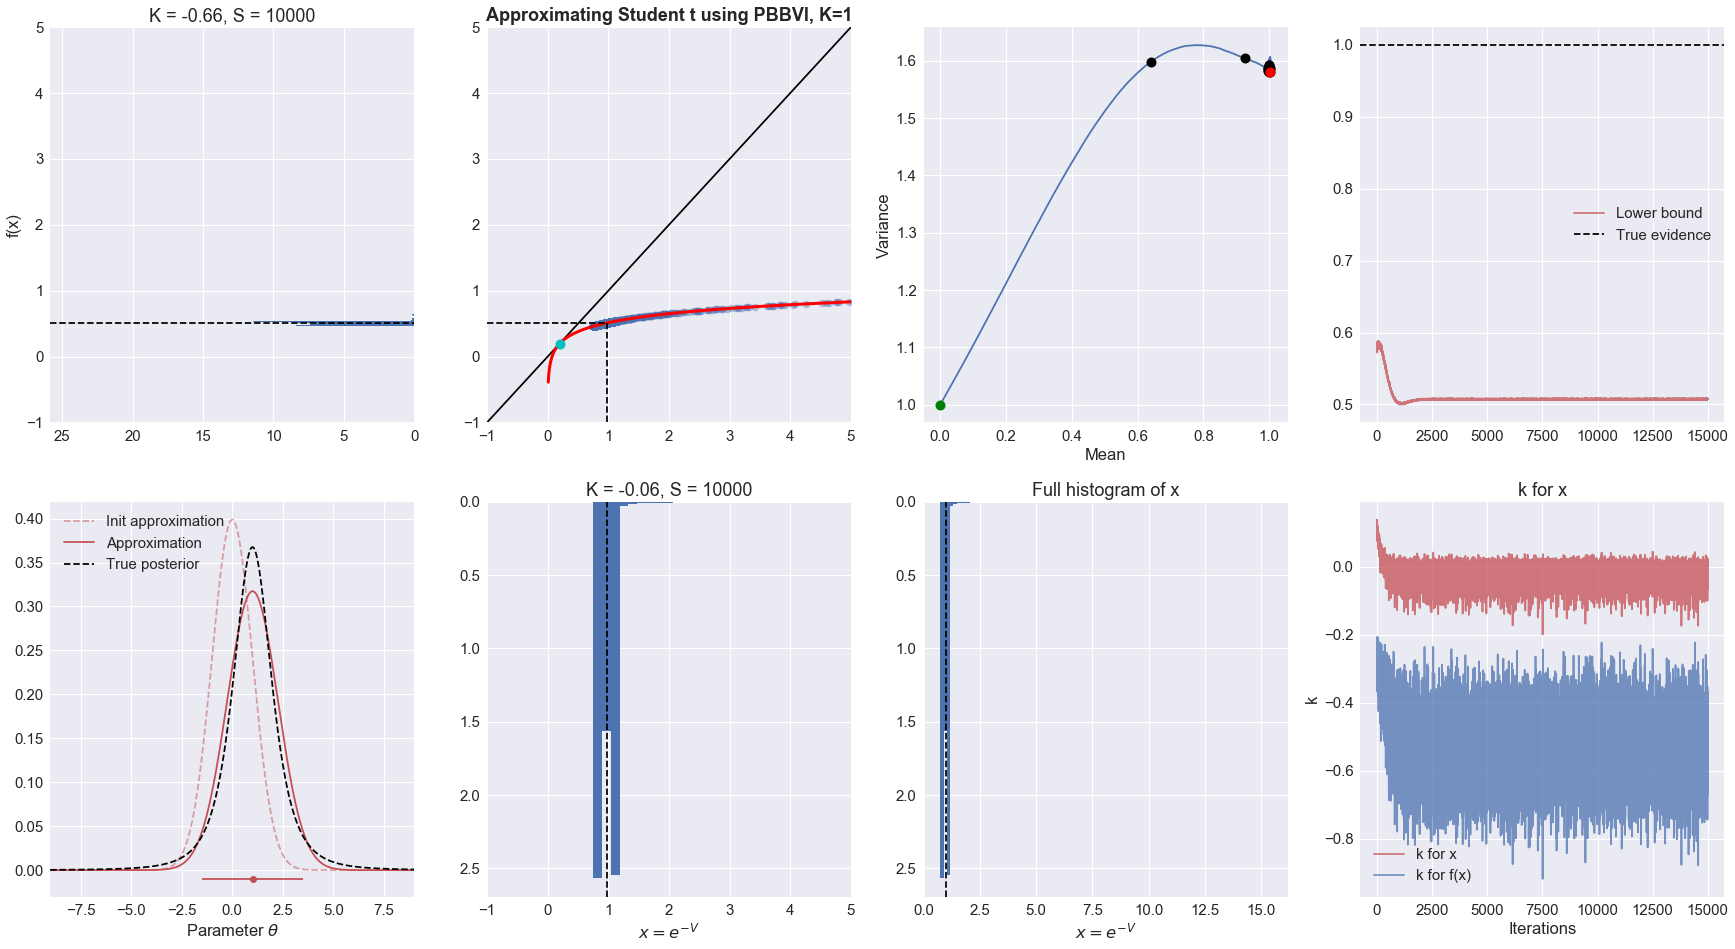

In [6]:
target_list = ['Student t']#, 'MoG1', 'MoG2']
function_list = ['PBBVI, K=1']#, 'PBBVI, K=3', 'PBBVI, K=5', 'alpha=0.5', 'IS']

#target_list = ['Student t']
#function_list = ['PBBVI, K=1']

for target_name in target_list:
    for function_name in function_list:

        print(100*'-')
        print('Approximating %s using %s' % (target_name, function_name))
        print(100*'-')
        make_figure(function_name, target_name, num_samples = 10000, seed = 0, max_itt=15000, log=False, learning_rate=1e-3)

In [1]:
lowerbounds

NameError: name 'lowerbounds' is not defined